In [1]:
import fastai
from fastai import *
from fastai.vision import *
from fastai.callbacks import * 
from fastai.vision.gan import *

In [2]:
path = untar_data(URLs.PETS)
path_hr = path/'images'
path_lr = path/'crappy'

In [3]:
from PIL import Image, ImageDraw,ImageFont

In [4]:
def crappify(fn,i):
    dest = path_lr/fn.relative_to(path_hr)
    dest.parent.mkdir(parents=True, exist_ok=True)
    img = PIL.Image.open(fn)
    targ_sz = resize_to(img, 96, use_min=True)
    img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
    w,h = img.size
    q = random.randint(10,70)
    ImageDraw.Draw(img).text((random.randint(0,w//2),random.randint(0,h//2)), str(q), fill=(255,255,255))
    img.save(dest, quality=q)

In [5]:
il = ImageImageList.from_folder(path_hr)
parallel(crappify, il.items)

In [6]:
bs, size = 32,128

In [7]:
arch = models.resnet34

In [8]:
src = ImageImageList.from_folder(path_lr).split_by_rand_pct(0.1, seed=42)

In [9]:
def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_hr/x.name)
            .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
            .databunch(bs=bs).normalize(imagenet_stats, do_y = True))
    
    data.c=3
    return data

In [10]:
data_gen = get_data(bs,size)

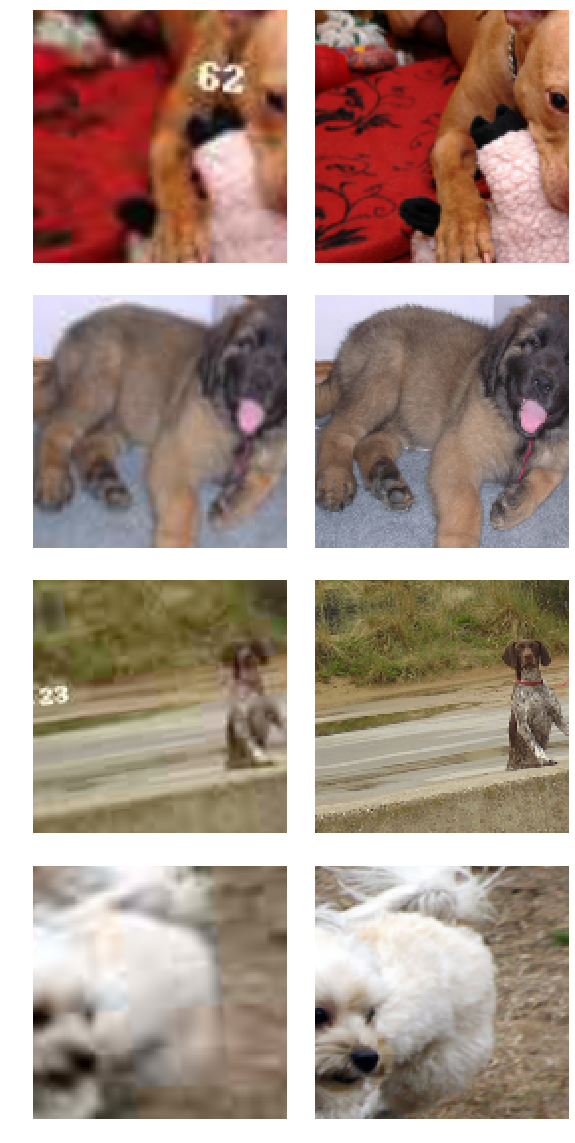

In [11]:
data_gen.show_batch(4)

In [12]:
wd = 1e-3
y_range = (-3.,3.)

In [13]:
loss_gen = MSELossFlat()

In [14]:
def create_gen_learner():
    return unet_learner(data_gen, arch, wd=wd, blur=True, norm_type=NormType.Weight, 
                       self_attention=True, y_range=y_range, loss_func=loss_gen)

In [15]:
learn_gen = create_gen_learner()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /tmp/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:04<00:00, 18857377.81it/s]


In [16]:
learn_gen.fit_one_cycle(2, pct_start=0.8)

In [17]:
learn_gen.unfreeze()

In [18]:
learn_gen.fit_one_cycle(3, slice(1e-6, 1e-3))

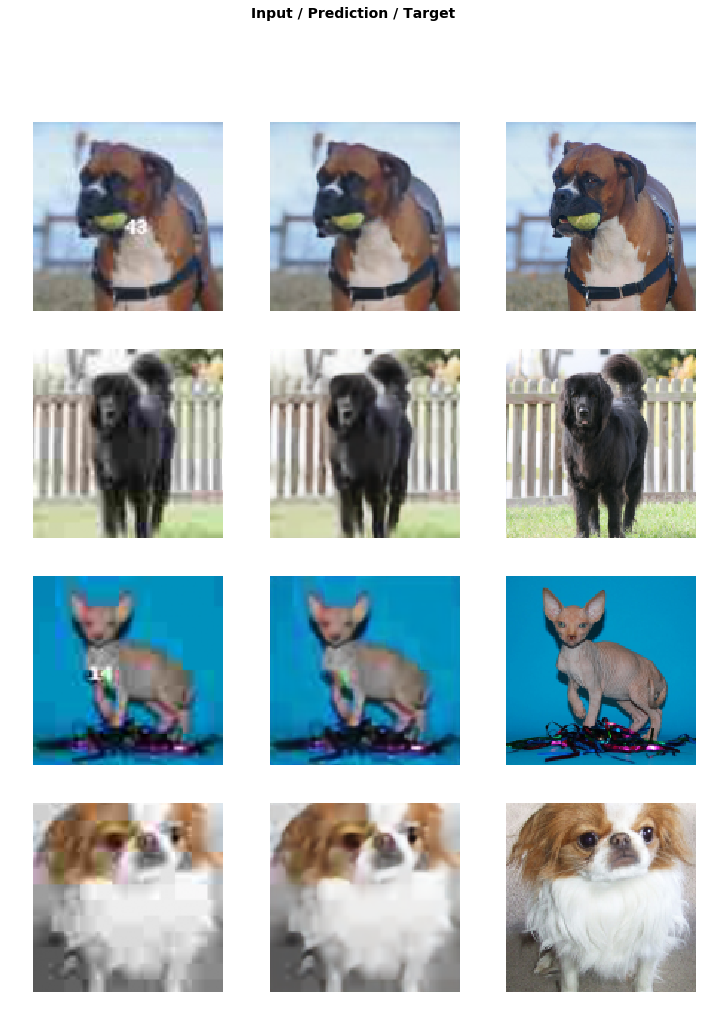

In [19]:
learn_gen.show_results(rows=4)

In [20]:
learn_gen.save('gen-pre2')

In [21]:
learn_gen.load('gen-pre2')

Learner(data=ImageDataBunch;

Train: LabelList (6651 items)
x: ImageImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
Path: /tmp/.fastai/data/oxford-iiit-pet/crappy;

Valid: LabelList (739 items)
x: ImageImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
Path: /tmp/.fastai/data/oxford-iiit-pet/crappy;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ce

In [22]:
name_gen = 'image_gen'

In [23]:
path_gen = path/name_gen

In [24]:
path_gen.mkdir(exist_ok=True)

In [25]:
def save_preds(dl):
    i=0
    names = dl.dataset.items
    
    for b in dl:
        preds = learn_gen.pred_batch(batch = b, reconstruct=True)
        for o in preds:
            o.save(path_gen/names[i].name)
            i += 1

In [26]:
save_preds(data_gen.fix_dl)

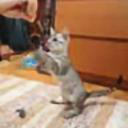

In [27]:
PIL.Image.open(path_gen.ls()[0])

In [28]:
learn_gen=None
gc.collect()

0

In [29]:
def get_crit_data(classes, bs, size):
    src = ImageList.from_folder(path, include=classes).split_by_rand_pct(0.1, seed=42)
    ll = src.label_from_folder()
    data = (ll.transform(get_transforms(max_zoom=2.), size=size)
           .databunch(bs=bs).normalize(imagenet_stats))
    data.c=3
    return data

In [30]:
data_crit = get_crit_data([name_gen, 'images'], bs=bs, size=size)

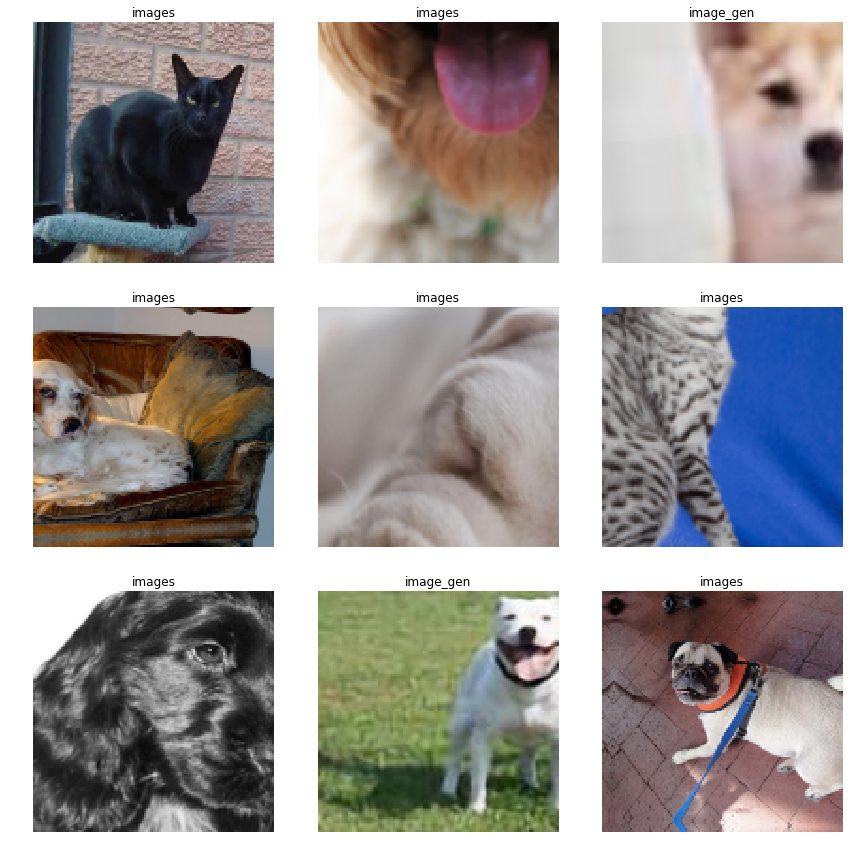

In [31]:
data_crit.show_batch(rows=3, ds_type=DatasetType.Train, imsize=3)

In [32]:
loss_critic = AdaptiveLoss(BCEWithLogitsFlat())

In [33]:
def create_critic_learner(data,metrics):
    return Learner(data, gan_critic(), metrics=metrics, loss_func=loss_critic, wd=wd)

In [34]:
learn_critic = create_critic_learner(data_crit, accuracy_thresh_expand)

In [35]:
learn_critic.fit_one_cycle(6, 1e-3)

In [36]:
learn_critic.save('critic-pre2')

In [37]:
learn_crit=None
learn_gen=None
gc.collect()

17839

In [38]:
data_crit = get_crit_data(['crappy', 'images'], bs=bs, size=size)

In [39]:
learn_crit = create_critic_learner(data_crit, metrics=None).load('critic-pre2')

In [40]:
learn_gen = create_gen_learner().load('gen-pre2')

In [41]:
switcher = partial(AdaptiveGANSwitcher, critic_thresh=0.65)
learn = GANLearner.from_learners(learn_gen, learn_crit, weights_gen=(1.,50.), 
                                 show_img=True, switcher=switcher, 
                                 opt_func=partial(optim.Adam, betas=(0.,0.99)),wd=wd)
learn.callback_fns.append(partial(GANDiscriminativeLR, mult_lr=5.))

In [42]:
lr = 1e-4

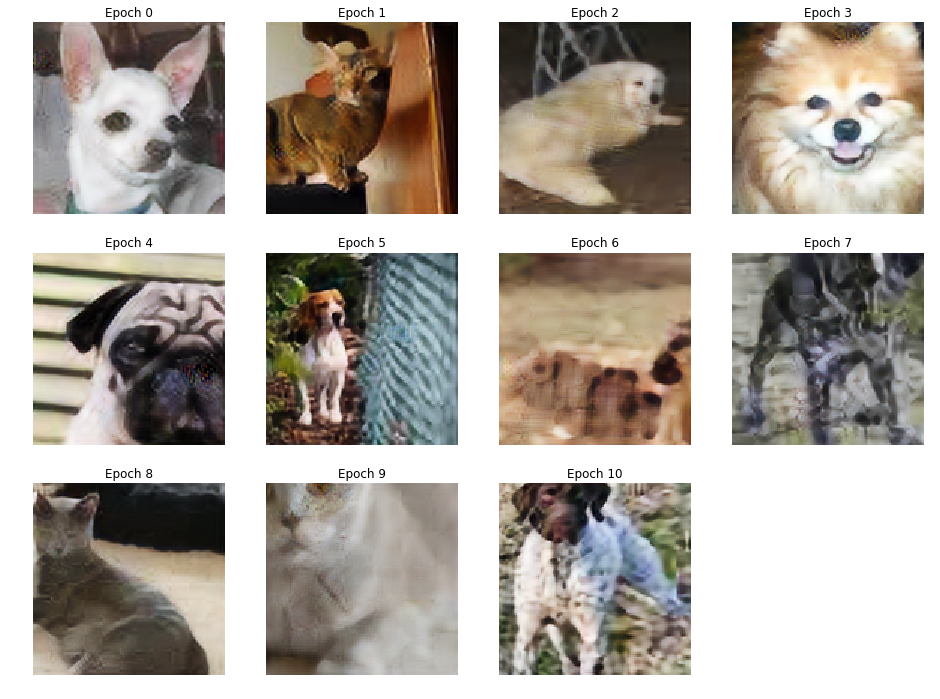

In [43]:
learn.fit(40,lr)

In [44]:
learn.save('gan-1c')

In [45]:
learn.data = get_data(16,192)

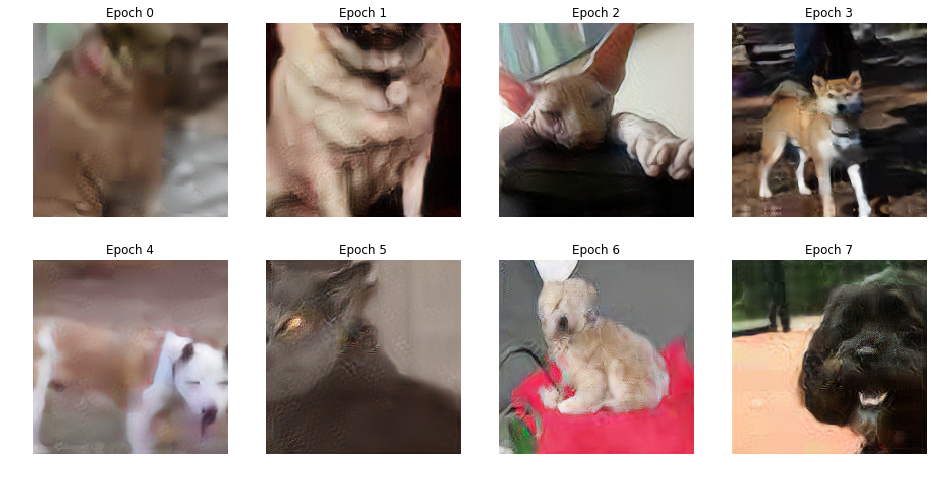

In [46]:
learn.fit(10,lr/2)

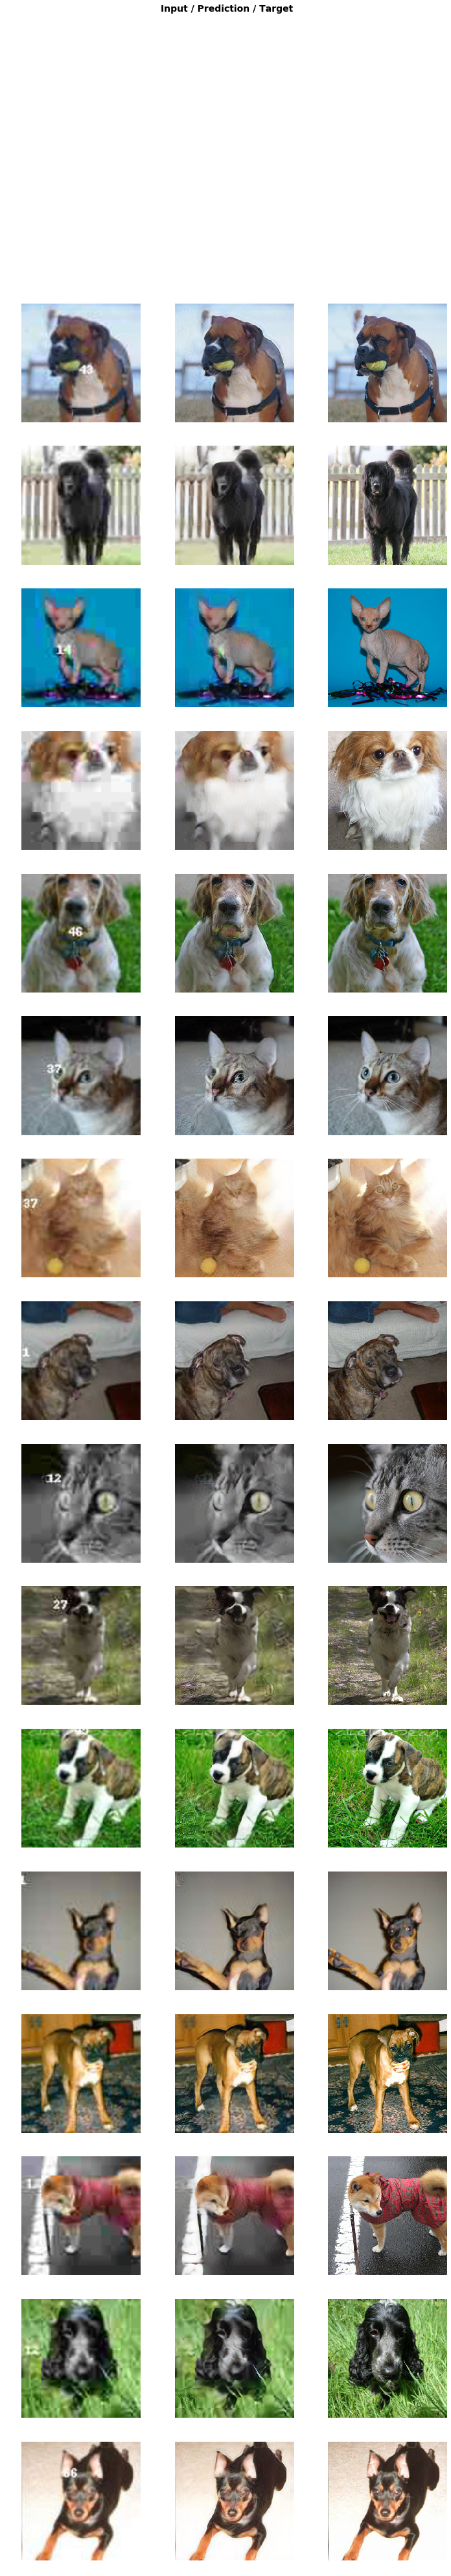

In [47]:
learn.show_results(rows=16)

In [48]:
learn.save('gan-1c')